In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import itertools
import cv2
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import iplot
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model
import plotly.express as px
import random
import zipfile
from PIL import Image
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import logging
tf.get_logger().setLevel(logging.ERROR)

/home/mattmori/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2024-03-13 16:53:17.519913: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-13 16:53:17.980822: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-13 16:53:17.980884: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-13 16:53:18.066139: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cu

Define Data Path and Data Set Name

In [2]:
# Generate dataframe of the image paths and the corresponding label
data_dir = 'pet_images'

def gen_df_from_directory(data_dir):
    #Identifies and stores filepaths to images in images variables
    #Labels images according to the file they were found in.
    
    image_paths = []
    labels = []

    files = os.listdir(data_dir)
    for file in files:
        if file == 'Master Folder':
            continue
            
        filepath = os.path.join(data_dir, file)
        imagelist = os.listdir(filepath)
        
        for im in imagelist:
            im_path = os.path.join(filepath, im)
            image_paths.append(im_path)
            labels.append(file)
    
    col_1 = pd.Series(image_paths, name= 'image_paths')
    col_2 = pd.Series(labels, name='labels')
    df = pd.concat([col_1, col_2], axis= 1)


    return image_paths, labels, df


image_paths, labels, df = gen_df_from_directory(data_dir)

In [3]:
df.head()

image_paths labels
0  pet_images/Angry/02.jpg  Angry
1  pet_images/Angry/03.jpg  Angry
2  pet_images/Angry/04.jpg  Angry
3  pet_images/Angry/05.jpg  Angry
4  pet_images/Angry/06.jpg  Angry

In [4]:
def explore_data(df, name='df'):
    num_images = df.shape[0]
    num_classes = len(df['labels'].unique())
    
    print(f"This dataset has {num_images} images and {num_classes} classes.")
    print()
    print("There are:")
   
    for label, group in df.groupby('labels'):
        num_class = len(group)
        print(f"{num_class} {label} images")
        
        
explore_data(df)

This dataset has 1005 images and 4 classes.

There are:
250 Angry images
255 Other images
250 Sad images
250 happy images


Define Data Path and Data Set Name

Spliting the dataframe into train, valid, and test

In [5]:
train_df, temp_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)
valid_df, test_df = train_test_split(temp_df,  train_size= 0.6, shuffle= True, random_state= 123)

In [6]:
explore_data(train_df)

This dataset has 804 images and 4 classes.

There are:
195 Angry images
216 Other images
193 Sad images
200 happy images


In [7]:
explore_data(valid_df)

This dataset has 120 images and 4 classes.

There are:
31 Angry images
25 Other images
31 Sad images
33 happy images


In [8]:
explore_data(test_df)

This dataset has 81 images and 4 classes.

There are:
24 Angry images
14 Other images
26 Sad images
17 happy images


Create Image Data Generator

In [9]:
batch_size = 24
img_size = (224, 224)
rgb = 3
img_shape = (img_size[0], img_size[1], rgb)

def scalar(img):
    return img

pre_train_gen = ImageDataGenerator(preprocessing_function= scalar,
                           rotation_range=25,
                           width_shift_range=0.25,
                           height_shift_range=0.25,
                           zoom_range=0.25)
             

pre_test_gen = ImageDataGenerator(preprocessing_function= scalar,
                           rotation_range=25,
                           width_shift_range=0.25,
                           height_shift_range=0.25,
                           zoom_range=0.25)

train_gen = pre_train_gen.flow_from_dataframe(train_df, 
                                        x_col= 'image_paths', 
                                        y_col= 'labels', 
                                        target_size= img_size, 
                                        class_mode= 'categorical',
                                        color_mode= 'rgb', 
                                        shuffle= True, 
                                        batch_size= batch_size)

valid_gen = pre_test_gen.flow_from_dataframe(valid_df, 
                                        x_col= 'image_paths', 
                                        y_col= 'labels', 
                                        target_size= img_size, 
                                        class_mode= 'categorical',
                                        color_mode= 'rgb', 
                                        shuffle= True, 
                                        batch_size= batch_size)


test_gen = pre_test_gen.flow_from_dataframe(test_df, 
                                       x_col= 'image_paths', 
                                       y_col= 'labels', 
                                       target_size= img_size, 
                                       class_mode= 'categorical',
                                       color_mode= 'rgb', 
                                       shuffle= False, 
                                       batch_size= batch_size)

Found 804 validated image filenames belonging to 4 classes.
Found 120 validated image filenames belonging to 4 classes.
Found 81 validated image filenames belonging to 4 classes.


Visualizing the Data Set

In [10]:
counts = df['labels'].value_counts()
fig = go.Figure(go.Bar(
            x= counts.values,
            y=counts.index,
            orientation='h'))

fig.update_layout(title='Data Distribution',font_size=15,title_x=0.45)

In [11]:
Happy = df.groupby("labels").get_group("happy")
Sad = df.groupby("labels").get_group("Sad")
Angry = df.groupby("labels").get_group("Angry")
Other = df.groupby("labels").get_group("Other")

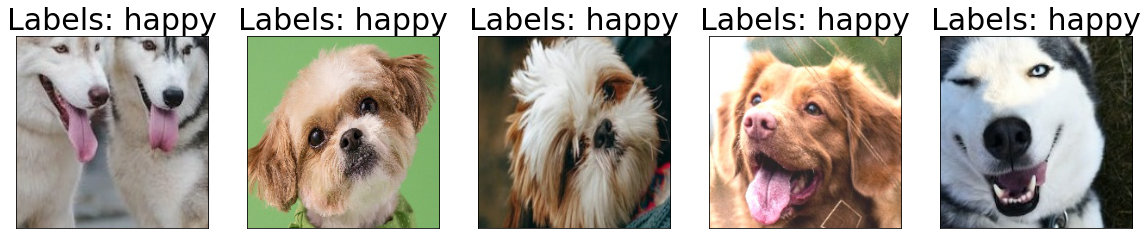

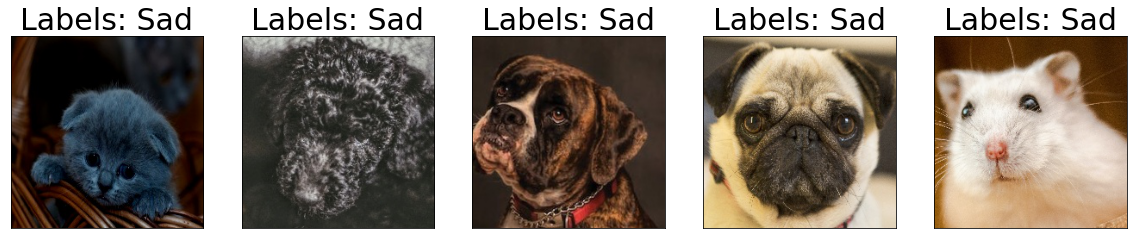

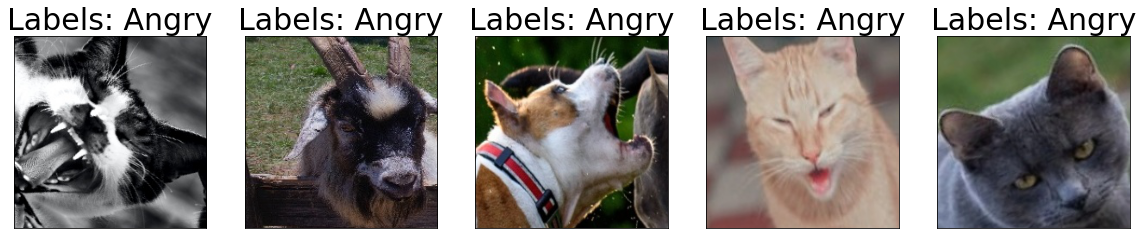

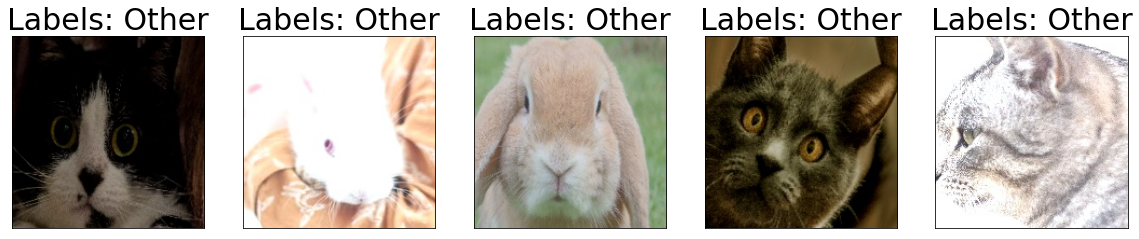

In [12]:
def plot_emotions(emotion):
    fig, axes = plt.subplots(ncols = 5,nrows = 1, figsize=(20, 20))
    for i in range(0,5):
        index = random.sample(range(len(emotion)),1)
        index = int(''.join(map(str, index)))

        filename = emotion.iloc[index]["image_paths"]
        label = emotion.iloc[index]["labels"]
        image = Image.open(filename)
        axes[i].imshow(image)
        axes[i].set_title("Labels: " + label, fontsize = 30)
        for ax in axes:
            ax.set_xticks([])
            ax.set_yticks([])
    

    plt.show()
    
plot_emotions(Happy)
plot_emotions(Sad)
plot_emotions(Angry)
plot_emotions(Other)

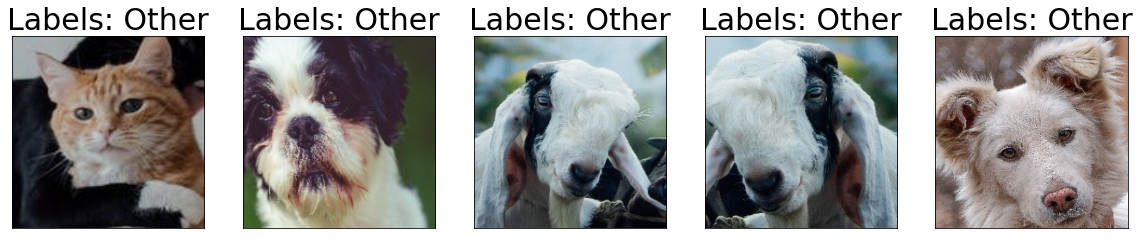

In [13]:
def show_similar_img(label):
    if label == "Angry":
        plot_emotions(Angry)
    elif label == "Other":
        plot_emotions(Other)
    elif label == "Sad":
        plot_emotions(Sad)
    elif label == "Happy":
        plot_emotions(Happy)

show_similar_img("Other")

Creating the Plot

In [14]:
img_size = (300, 300)
rgb = 3
img_shape = (img_size[0], img_size[1], rgb)
class_count = len(list(train_gen.class_indices.keys())) 

#EfficientnetB3
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", drop_connect_rate = 0.60, input_shape= img_shape, pooling= 'max')
base_model.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(),
    #Transfer Learning: Classifies features extracted by the model
    Dense(256, activation='relu'),
    Dense(class_count, activation= 'softmax')
])
model.summary()

2024-03-13 16:53:30.409984: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:3b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-13 16:53:30.410787: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1536)              6144      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 11184179 (42.66 MB)
Trainable params: 397572 (1.52 MB)
Non-trainable params: 10786607 (41.15 MB)
_________________________________________________________________


Compiling the Model

In [15]:
model.compile(optimizer = SGD(learning_rate=0.1), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

Training the Model

In [16]:
step_size_train= train_gen.n // train_gen.batch_size
step_size_valid= valid_gen.n // valid_gen.batch_size

import time
start_time = time.time()
batch_size = 16  
history = model.fit(x=train_gen,
                    epochs= 100,
                    verbose= 1,
                    steps_per_epoch = step_size_train,
                    validation_data= valid_gen, 
                    validation_steps= step_size_valid)

print("My program took", time.time() - start_time, "to run")


Epoch 1/100
33/33 [==============================] - 62s 2s/step - loss: 1.8312 - accuracy: 0.3769 - val_loss: 1.6909 - val_accuracy: 0.4500
Epoch 2/100
33/33 [==============================] - 52s 2s/step - loss: 1.2254 - accuracy: 0.5141 - val_loss: 1.0986 - val_accuracy: 0.5167
Epoch 3/100
33/33 [==============================] - 51s 2s/step - loss: 1.1222 - accuracy: 0.5500 - val_loss: 0.8635 - val_accuracy: 0.6667
Epoch 4/100
33/33 [==============================] - 55s 2s/step - loss: 0.9883 - accuracy: 0.6385 - val_loss: 0.9111 - val_accuracy: 0.6417
Epoch 5/100
33/33 [==============================] - 56s 2s/step - loss: 0.9224 - accuracy: 0.6436 - val_loss: 0.6036 - val_accuracy: 0.7917
Epoch 6/100
33/33 [==============================] - 49s 1s/step - loss: 0.9102 - accuracy: 0.6513 - val_loss: 0.6412 - val_accuracy: 0.7750
Epoch 7/100
33/33 [==============================] - 51s 2s/step - loss: 0.7543 - accuracy: 0.7051 - val_loss: 0.6828 - val_accuracy: 0.7750
Epoch 8/100
3

Epoch 59/100
33/33 [==============================] - 51s 2s/step - loss: 0.1818 - accuracy: 0.9410 - val_loss: 0.3743 - val_accuracy: 0.8917
Epoch 60/100
33/33 [==============================] - 48s 1s/step - loss: 0.1868 - accuracy: 0.9308 - val_loss: 0.3430 - val_accuracy: 0.9083
Epoch 61/100
33/33 [==============================] - 49s 1s/step - loss: 0.1526 - accuracy: 0.9538 - val_loss: 0.4017 - val_accuracy: 0.8583
Epoch 62/100
33/33 [==============================] - 49s 1s/step - loss: 0.1942 - accuracy: 0.9346 - val_loss: 0.2722 - val_accuracy: 0.9333
Epoch 63/100
33/33 [==============================] - 53s 2s/step - loss: 0.1474 - accuracy: 0.9487 - val_loss: 0.2527 - val_accuracy: 0.9333
Epoch 64/100
33/33 [==============================] - 52s 2s/step - loss: 0.1847 - accuracy: 0.9449 - val_loss: 0.2322 - val_accuracy: 0.9417
Epoch 65/100
33/33 [==============================] - 49s 1s/step - loss: 0.2344 - accuracy: 0.9308 - val_loss: 0.2940 - val_accuracy: 0.9250
Epoch 

Evaluating the Model

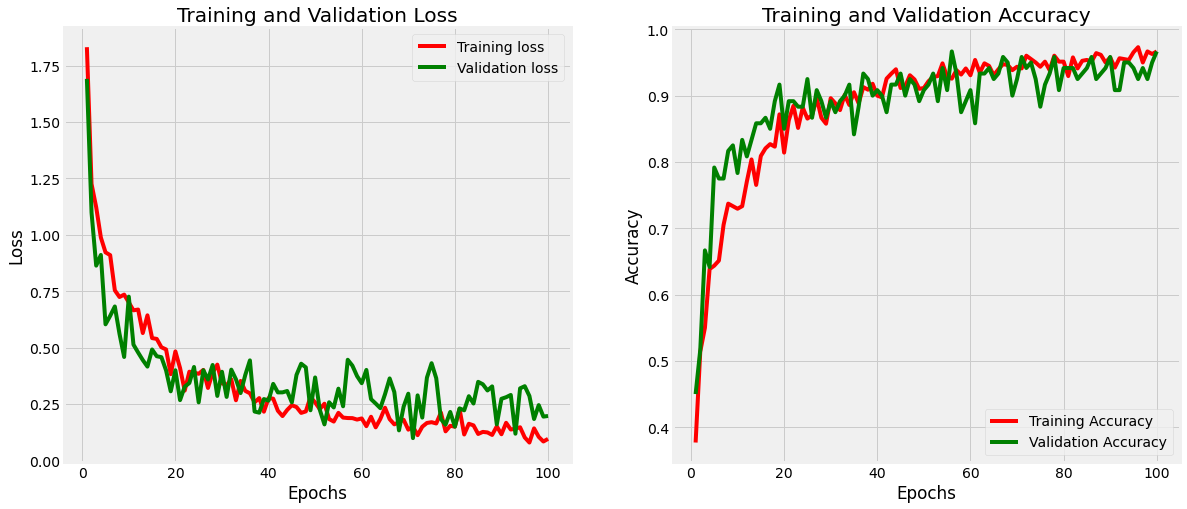

In [17]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
Epochs = [i+1 for i in range(len(tr_acc))]

# Plot training history

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

Model Accuracy 

In [18]:
train_score = model.evaluate(train_gen, steps= batch_size, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= batch_size, verbose= 1)
test_score = model.evaluate(test_gen, steps= batch_size, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])


16/16 [==============================] - 5s 229ms/step - loss: 0.1158 - accuracy: 0.9877
Train Loss:  0.0054446193389594555
Train Accuracy:  0.9973958134651184
--------------------
Validation Loss:  0.25550949573516846
Validation Accuracy:  0.9583333134651184
--------------------
Test Loss:  0.11583994328975677
Test Accuracy:  0.9876543283462524


Getting the Prediction 

/tmp/ipykernel_54/1212715644.py:1: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.

/tmp/ipykernel_54/1212715644.py:13: MatplotlibDeprecationWarning:

Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.



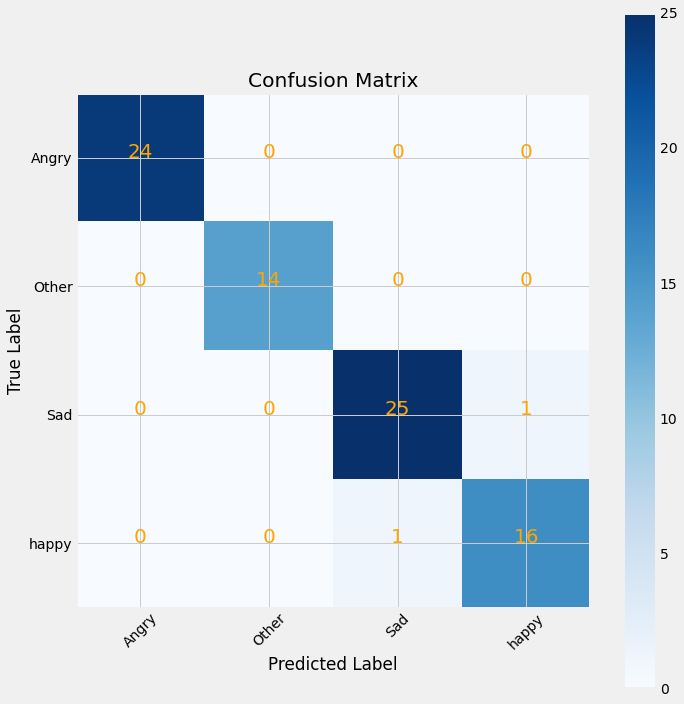

In [19]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)


classes = list(test_gen.class_indices.keys())


cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'orange', fontsize = 20)

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [31]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

       Angry       1.00      1.00      1.00        24
       Other       1.00      1.00      1.00        14
         Sad       0.96      0.96      0.96        26
       happy       0.94      0.94      0.94        17

    accuracy                           0.98        81
   macro avg       0.98      0.98      0.98        81
weighted avg       0.98      0.98      0.98        81



Loading the Model and Predicting Inputs!

1/1 [==============================] - 0s 119ms/step


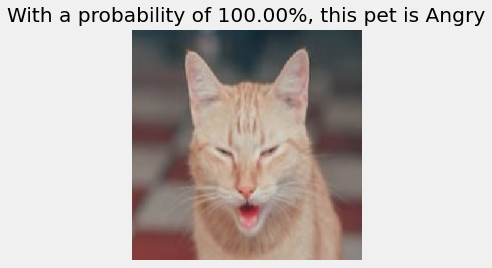

In [35]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

def predict_emotion(image_path, model):
    fig, ax = plt.subplots()
    img = image.load_img(image_path, target_size=(300, 300))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    
    pred = model.predict(img_array)
    acc = np.max(pred)
    acc = "{:.2f}".format(100*acc)
    pred_class_index = np.argmax(pred)
    
    class_indices = train_gen.class_indices
    class_labels = list(class_indices.keys())
    pred_label = class_labels[pred_class_index]
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    plt.imshow(img)
    
    
    #plt.axis('off')
    if pred_label == 'Other':
        plt.title(f"With a probability of {acc}%, this pet is content")
    else:
        plt.title(f"With a probability of {acc}%, this pet is {pred_label}")
    plt.show()



test_img = "pet_images/Angry/02.jpg"
predict_emotion(test_img, model)

In [36]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(train_gen.classes)
y_onehot_test = label_binarizer.transform(test_gen.classes)
y_onehot_test.shape  # (n_samples, n_classes)


train_gen.class_indices.keys()

dict_keys(['Angry', 'Other', 'Sad', 'happy'])

In [37]:
blank_probs = [0 for i in range(len(preds))]

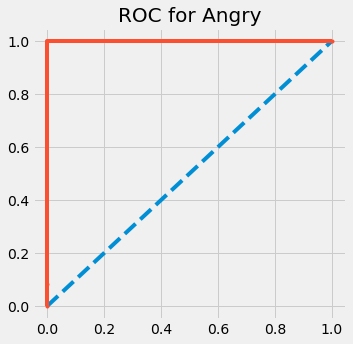

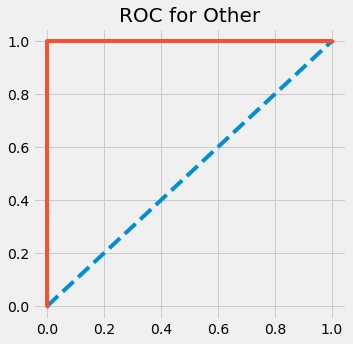

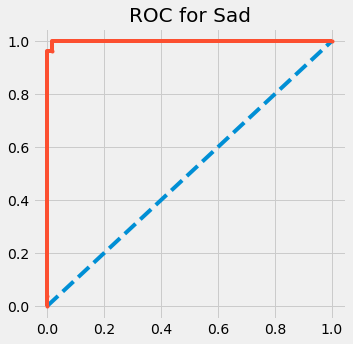

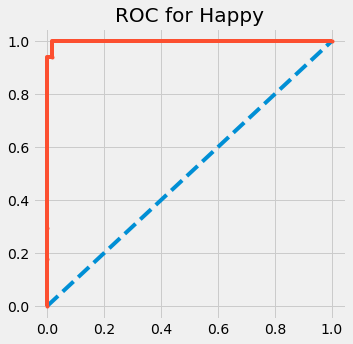

In [38]:
from sklearn.metrics import roc_curve
class_labels = ['Angry', 'Other', 'Sad', 'Happy']
for i in range(0,4):
    fig, axes = plt.subplots(ncols = 1,nrows = 1, figsize=(5, 5))
    fpr, tpr, thresholds = roc_curve(y_onehot_test[:,i], preds[:,i])
    b_fpr, b_tpr, b_thresholds = roc_curve(y_onehot_test[:,i], blank_probs)
    plt.plot(b_fpr, b_tpr, linestyle='--', label='baseline')
    plt.plot(fpr, tpr, marker='.', label='model')
    axes.set_title(f"ROC for {class_labels[i]}", fontsize = 20)

In [34]:
#model.save("98_model.h5")

/home/mattmori/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

